<a href="https://colab.research.google.com/github/matthewpblock/applied-ml-matthew-block/blob/main/notebooks/project05/ensemble-block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5 - Ensemble Modeling
Matthew Block  
23 NOV 2025

## Introduction
[short introduction]

In [44]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

## Section 1. Load and Inspect the Data

In [45]:
df = pd.read_csv("winequality-red.csv", sep=";")
# Display structure and first few rows
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


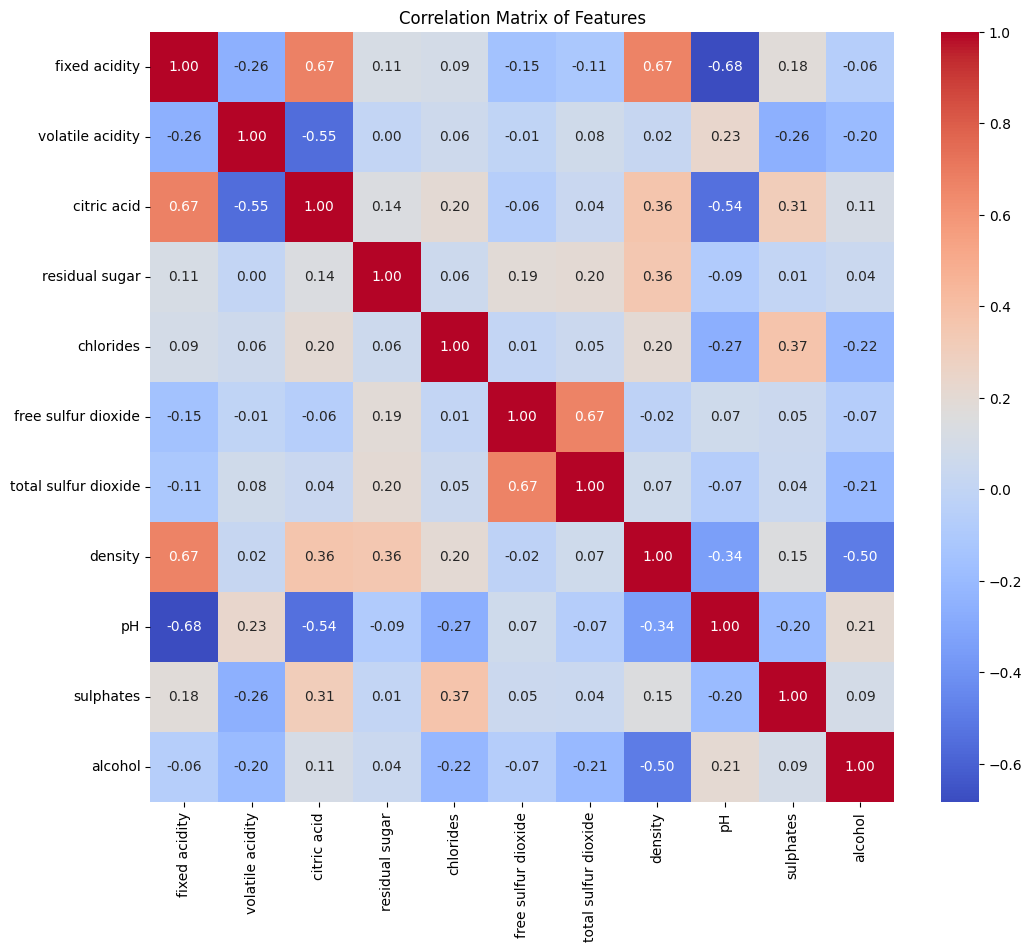


Features sorted by their correlation to 'quality':
quality                 1.000000
quality_numeric         0.812367
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


In [64]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

# Calculate correlation with 'quality' and sort
# Drop non-numeric columns before calculating correlation
quality_correlation = df.drop(columns=['quality_label']).corr()['quality'].sort_values(ascending=False)
print("\nFeatures sorted by their correlation to 'quality':")
print(quality_correlation)

I checked the correlation matrix to determine which features are best candidates to be ignored based on low correlation, and also to see if any features may be able to serve as proxies for each other. This info can help us build more efficient models.

## Section 2. Prepare the Data

Includes cleaning, feature engineering, encoding, splitting, helper functions


In [46]:
# Define helper function that:
# Takes one input, the quality (which we will temporarily name q while in the function)
# And returns a string of the quality label (low, medium, high)
# This function will be used to create the quality_label column
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

# Call the apply() method on the quality column to create the new quality_label column
df["quality_label"] = df["quality"].apply(quality_to_label)

# Then, create a numeric column for modeling: 0 = low, 1 = medium, 2 = high
def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df["quality_numeric"] = df["quality"].apply(quality_to_number)
print(df.head)

<bound method NDFrame.head of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067  

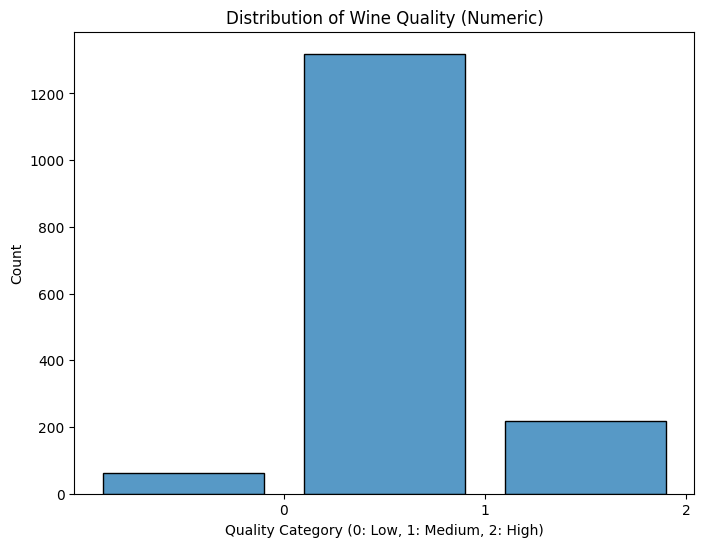

In [68]:
plt.figure(figsize=(8, 6))
sns.histplot(df['quality_numeric'], bins=[0, 1, 2, 3], discrete=True, shrink=0.8)
plt.title('Distribution of Wine Quality (Numeric)')
plt.xlabel('Quality Category (0: Low, 1: Medium, 2: High)')
plt.ylabel('Count')
plt.xticks([0.5, 1.5, 2.5], ['0', '1', '2']) # Center ticks for discrete bins
plt.show()

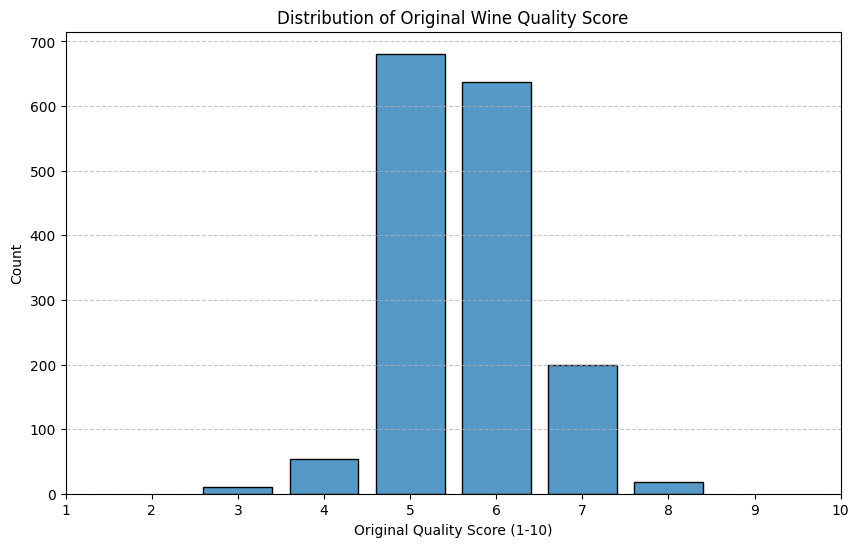

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(df['quality'], bins=range(1, 11), discrete=True, shrink=0.8)
plt.title('Distribution of Original Wine Quality Score')
plt.xlabel('Original Quality Score (1-10)')
plt.ylabel('Count')
plt.xticks(range(1, 11)) # Set x-ticks to correspond to each quality score
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It's interesting that we bundled the quality scores into less specific categories and then re-encoded the scores back to numbers. It seems like we likely gave away some of this signal through this process.

## Section 3. Feature Selection and Justification

In [47]:
# Define input features (X) and target (y)
# Features: all columns except 'quality' and 'quality_label' and 'quality_numberic' - drop these from the input array
# Target: quality_label (the new column we just created)
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])  # Features
y = df["quality_numeric"]  # Target

## Section 4. Split the Data into Train and Test

In [48]:
# Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Section 5.  Evaluate Model Performance

In [49]:
# Helper function to train and evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1,
        }
    )

results = []
# 1. Random Forest
evaluate_model(
    "Random Forest (100)",
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# 6. Voting Classifier (DT, SVM, NN)
voting1 = VotingClassifier(
    estimators=[
        ("DT", DecisionTreeClassifier()),
        ("SVM", SVC(probability=True)),
        ("NN", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ],
    voting="soft",
)
evaluate_model(
    "Voting (DT + SVM + NN)", voting1, X_train, y_train, X_test, y_test, results
)

# 9. MLP Classifier
evaluate_model(
    "MLP Classifier",
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)




Random Forest (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 256   8]
 [  0  15  28]]
Train Accuracy: 1.0000, Test Accuracy: 0.8875
Train F1 Score: 1.0000, Test F1 Score: 0.8661

Voting (DT + SVM + NN) Results
Confusion Matrix (Test):
[[  0  12   1]
 [  0 247  17]
 [  0  18  25]]
Train Accuracy: 0.9273, Test Accuracy: 0.8500
Train F1 Score: 0.9122, Test F1 Score: 0.8315

MLP Classifier Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 257   7]
 [  0  30  13]]
Train Accuracy: 0.8514, Test Accuracy: 0.8438
Train F1 Score: 0.8141, Test F1 Score: 0.8073


In [50]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("Confusion matrix plotting function defined.")

Confusion matrix plotting function defined.


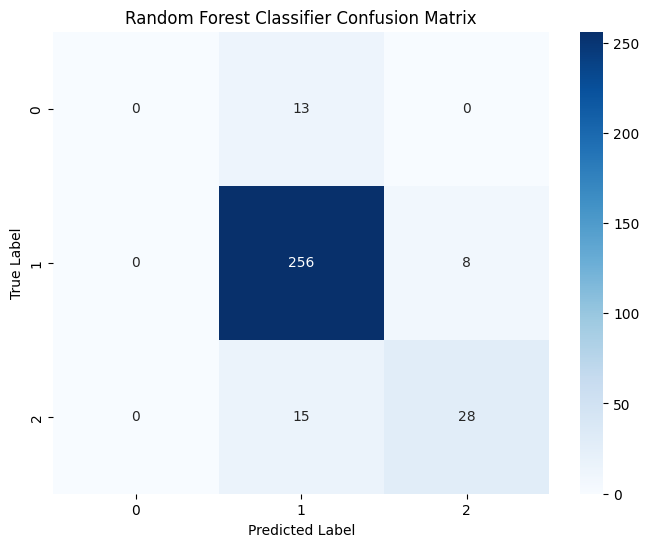

Random Forest Confusion Matrix plotted.


In [51]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)

plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest Classifier Confusion Matrix')
print("Random Forest Confusion Matrix plotted.")

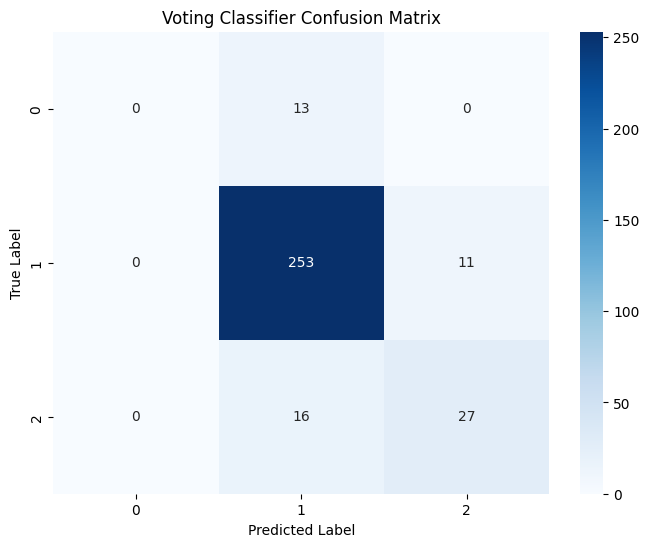

Voting Classifier Confusion Matrix plotted.


In [52]:
voting_model = VotingClassifier(
    estimators=[
        ("DT", DecisionTreeClassifier()),
        ("SVM", SVC(probability=True)),
        ("NN", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ],
    voting="soft",
)
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

plot_confusion_matrix(y_test, y_pred_voting, 'Voting Classifier Confusion Matrix')
print("Voting Classifier Confusion Matrix plotted.")

## Section 6. Compare Results

In [53]:
# Calculate the gap between Train and Test Accuracy
results_df['Accuracy Gap'] = results_df['Train Accuracy'] - results_df['Test Accuracy']

# Calculate the gap between Train and Test F1 Score
results_df['F1 Gap'] = results_df['Train F1'] - results_df['Test F1']

# Sort by Test Accuracy in descending order
results_df_sorted = results_df.sort_values(by="Test Accuracy", ascending=False)

# Display the final sorted results
print("\nFinal Model Comparison (Sorted by Test Accuracy):")
display(results_df_sorted)


Final Model Comparison (Sorted by Test Accuracy):


,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Accuracy Gap,F1 Gap
0,Random Forest (100),1.000000,0.887500,1.000000,0.866056,0.112500,0.133944
1,Voting (DT + SVM + NN),0.906959,0.865625,0.884147,0.843075,0.041334,0.041072
2,MLP Classifier,0.851446,0.843750,0.814145,0.807318,0.007696,0.006827


## Section 7. Conclusions and Insights

## Summary:

### Data Analysis Key Findings
*   **Top Performing Model**: The **Random Forest (100)** model achieved the highest ranking with a Test Accuracy of approximately **0.8875**.
*   **Runner-up Models**: The **Voting (DT + SVM + NN)** ensemble secured the second position with a Test Accuracy of **0.8656**, followed by the **MLP Classifier** at **0.8437**.
*   **Overfitting Indicators**: The calculation of metric gaps revealed significant differences for the top model. For instance, the Random Forest model showed an **Accuracy Gap of 0.1125** (Train: 1.0 vs. Test: 0.8875) and an **F1 Gap of 0.1339**, indicating perfect performance on training data but a drop on unseen test data.

### Insights or Next Steps
*   **Address Overfitting**: Since the Random Forest model exhibits a perfect training score but a noticeable gap in testing performance, hyperparameter tuning (e.g., limiting tree depth or increasing minimum samples per split) is recommended to improve generalization.
*   **Evaluate Ensemble Strategy**: The Voting classifier performed competitively; further experimenting with soft voting weights or adding the Random Forest model to the voting ensemble could potentially surpass individual model performance.


## Section 8: Further Analysis

# Task
Calculate and plot the permutation importance for the `random_forest_model`, `voting_model`, and `MLPClassifier` model using the `X_train`, `y_train`, `X_test`, and `y_test` data. For each model, display a bar plot of the feature importances.

**Reasoning**:
I will calculate the permutation importance for the `random_forest_model` using `X_test` and `y_test`, create a sorted DataFrame from the results, and then generate a horizontal bar plot to visualize the feature importances.



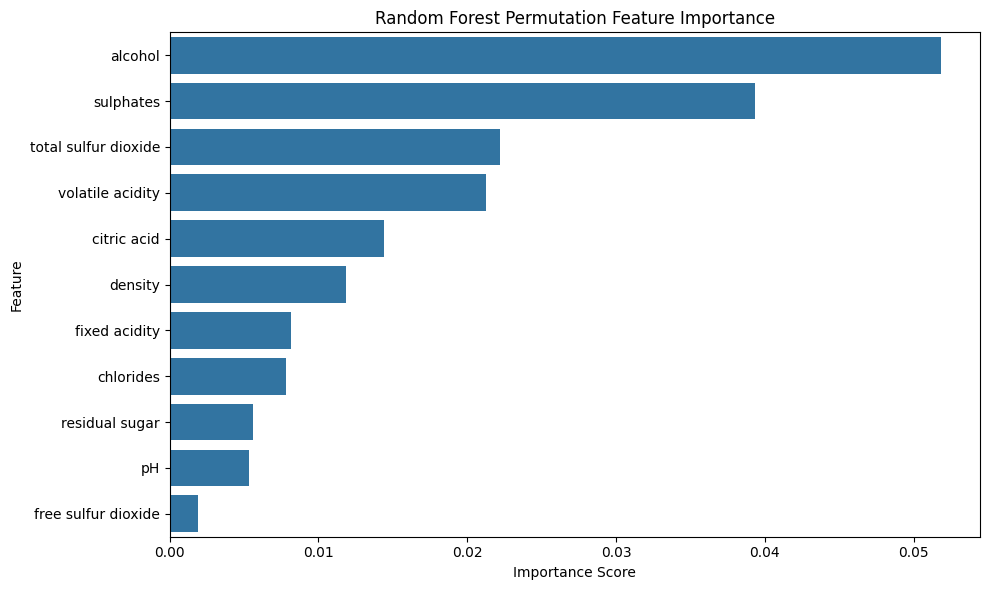

Permutation importance calculated and plotted for Random Forest.


In [54]:
rf_perm_importance = permutation_importance(
    random_forest_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

rf_importances_df = pd.DataFrame(
    {'Importance': rf_perm_importance.importances_mean},
    index=X_test.columns
)
rf_importances_df = rf_importances_df.sort_values(by='Importance', ascending=False).reset_index()
rf_importances_df.columns = ['Feature', 'Importance']

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importances_df)
plt.title('Random Forest Permutation Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Permutation importance calculated and plotted for Random Forest.")

**Reasoning**:
I will calculate the permutation importance for the `voting_model` using `X_test` and `y_test`, create a sorted DataFrame from the results, and then generate a horizontal bar plot to visualize the feature importances.



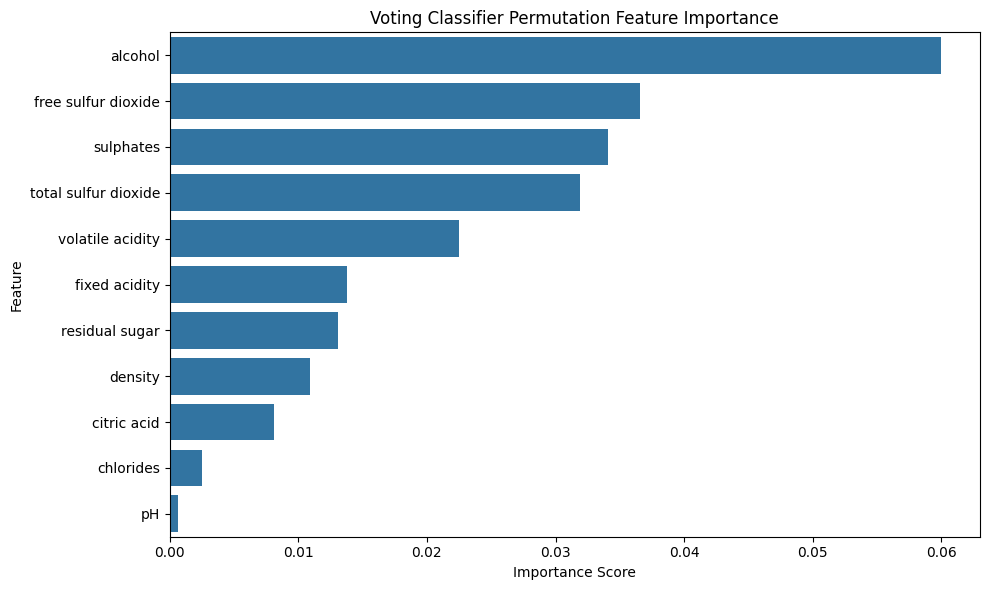

Permutation importance calculated and plotted for Voting Classifier.


In [55]:
voting_perm_importance = permutation_importance(
    voting_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

voting_importances_df = pd.DataFrame(
    {'Importance': voting_perm_importance.importances_mean},
    index=X_test.columns
)
voting_importances_df = voting_importances_df.sort_values(by='Importance', ascending=False).reset_index()
voting_importances_df.columns = ['Feature', 'Importance']

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=voting_importances_df)
plt.title('Voting Classifier Permutation Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Permutation importance calculated and plotted for Voting Classifier.")

**Reasoning**:
I will instantiate and train an `MLPClassifier` with the same parameters used previously, then calculate its permutation importance using `X_test` and `y_test`, create a sorted DataFrame from the results, and finally generate a horizontal bar plot to visualize the feature importances, following the pattern established for the previous models.



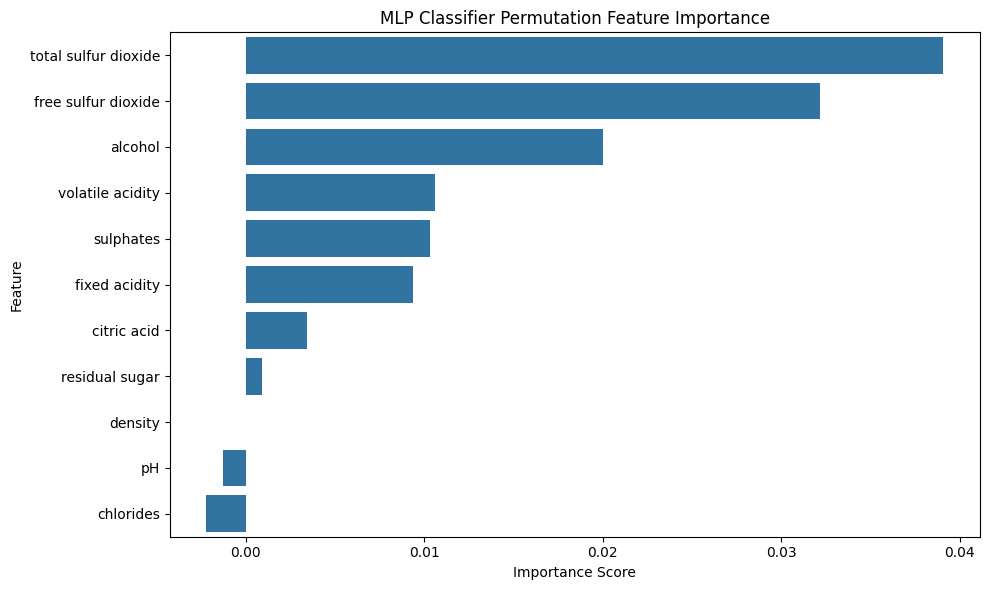

Permutation importance calculated and plotted for MLP Classifier.


In [56]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

mlp_perm_importance = permutation_importance(
    mlp_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

mlp_importances_df = pd.DataFrame(
    {'Importance': mlp_perm_importance.importances_mean},
    index=X_test.columns
)
mlp_importances_df = mlp_importances_df.sort_values(by='Importance', ascending=False).reset_index()
mlp_importances_df.columns = ['Feature', 'Importance']

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mlp_importances_df)
plt.title('MLP Classifier Permutation Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Permutation importance calculated and plotted for MLP Classifier.")

## Summary:

### Data Analysis Key Findings
*   Permutation importance was successfully calculated and visualized for all three specified models: `random_forest_model`, `voting_model`, and `MLPClassifier`.
*   For each model, a horizontal bar plot was generated, displaying features sorted by their importance scores derived from the permutation importance calculation.
*   The calculation process consistently used `n_repeats=10` and `random_state=42` for the `permutation_importance` function across all models.

### Insights or Next Steps
*   Compare the top-ranked features and their importance scores across the three models to identify consistently important features or significant discrepancies in feature relevance as perceived by different model architectures.
*   Utilize the identified important features for feature selection or engineering to potentially improve model performance or simplify the models.


# Task
Combine the permutation importance DataFrames for Random Forest, Voting Classifier, and MLP Classifier into a single DataFrame, adding a 'Model' column to each. Then, create a grouped bar chart to visualize the feature importances across all three models.

## Combine Permutation Importance DataFrames

### Subtask:
Combine the individual DataFrames containing permutation importances for Random Forest, Voting Classifier, and MLP Classifier into a single DataFrame, adding a 'Model' column for identification.


**Reasoning**:
To combine the permutation importance DataFrames, I will first add a 'Model' column to each individual DataFrame to identify the source model, then concatenate them vertically into a single DataFrame.



In [57]:
rf_importances_df['Model'] = 'Random Forest'
voting_importances_df['Model'] = 'Voting Classifier'
mlp_importances_df['Model'] = 'MLP Classifier'

combined_importances_df = pd.concat([
    rf_importances_df,
    voting_importances_df,
    mlp_importances_df
])

# Calculate the sum of feature importance across all models
feature_importance_sum = combined_importances_df.groupby('Feature')['Importance'].sum().reset_index()
feature_importance_sum.rename(columns={'Importance': 'Total Importance'}, inplace=True)

# Merge the total importance back to the combined DataFrame and sort
combined_importances_df = pd.merge(combined_importances_df, feature_importance_sum, on='Feature')
combined_importances_df_sorted = combined_importances_df.sort_values(by=['Total Importance', 'Importance'], ascending=[False, False])

print("Combined Permutation Importance DataFrame created and sorted by total importance.")
display(combined_importances_df_sorted.head())

Combined Permutation Importance DataFrame created and sorted by total importance.


,Feature,Importance,Model,Total Importance
11,alcohol,0.060000,Voting Classifier,0.131875
0,alcohol,0.051875,Random Forest,0.131875
24,alcohol,0.020000,MLP Classifier,0.131875
22,total sulfur dioxide,0.039062,MLP Classifier,0.093125
14,total sulfur dioxide,0.031875,Voting Classifier,0.093125


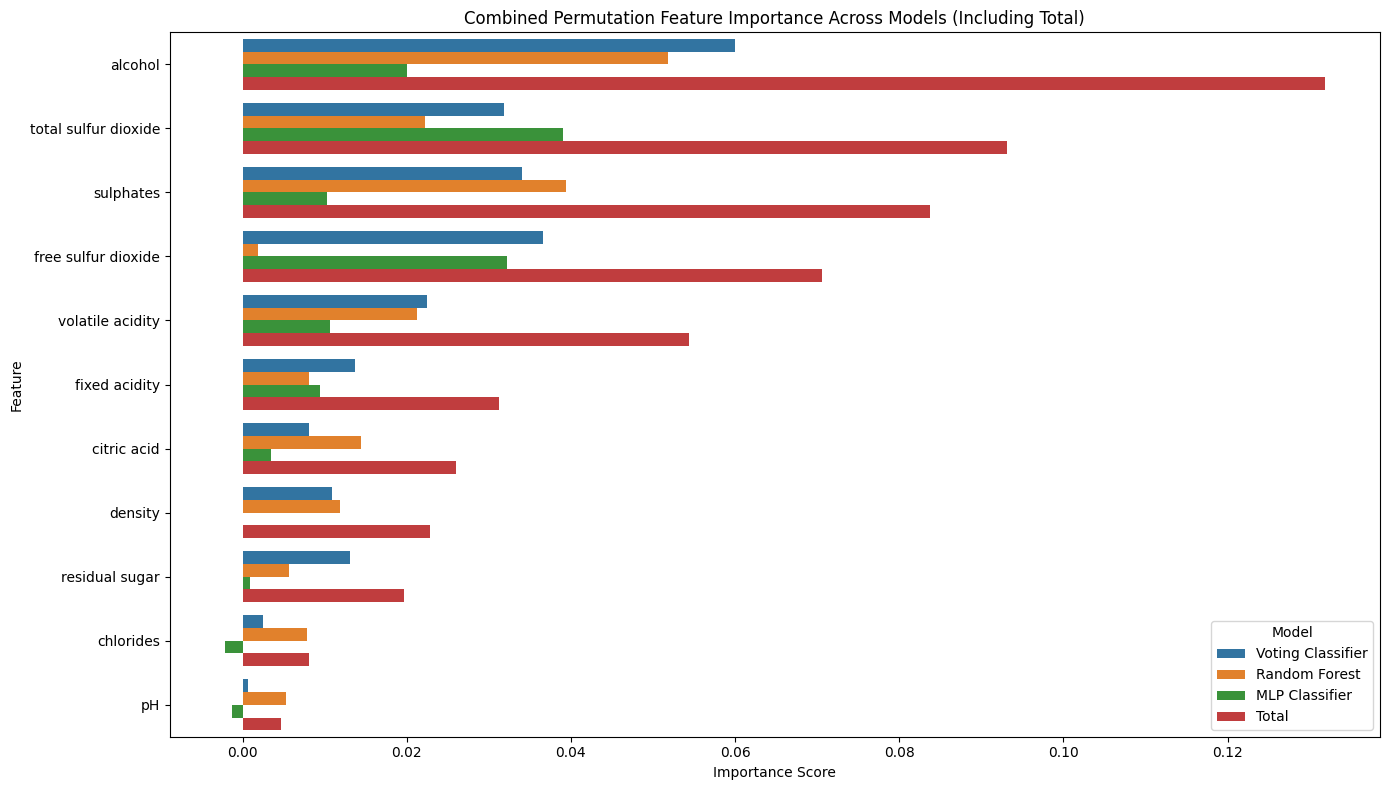

In [61]:
total_importances_for_plotting = combined_importances_df_sorted[['Feature', 'Total Importance']].drop_duplicates()
total_importances_for_plotting = total_importances_for_plotting.rename(columns={'Total Importance': 'Importance'})
total_importances_for_plotting['Model'] = 'Total'

# Concatenate the original sorted DataFrame with the new total importances DataFrame
final_plot_df = pd.concat([combined_importances_df_sorted.drop(columns=['Total Importance']), total_importances_for_plotting])

# Sort the features for consistent plotting order (based on total importance)
feature_order = combined_importances_df_sorted.groupby('Feature')['Total Importance'].first().sort_values(ascending=False).index

plt.figure(figsize=(14, 8)) # Increased figure size to accommodate more bars
sns.barplot(x='Importance', y='Feature', hue='Model', data=final_plot_df, order=feature_order)
plt.title('Combined Permutation Feature Importance Across Models (Including Total)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

Since the last three categories seem to provide little to no predictive value for quality, let's test a version of our highest performing model witht these three removed to see how it compares.

In [66]:
# Remove three more features
X = df.drop(columns=["quality", "quality_label", "quality_numeric", "pH", "chlorides", "residual sugar"])  # Features
y = df["quality_numeric"]  # Target

# Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check new model
results = []
# 1. Random Forest
evaluate_model(
    "Random Forest (100)",
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)


Random Forest (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  1 254   9]
 [  0  14  29]]
Train Accuracy: 1.0000, Test Accuracy: 0.8844
Train F1 Score: 1.0000, Test F1 Score: 0.8652


While the accuracy and F1 scores dropped very slightly, the are practically equivalent to the originaal Random Forest model's scores. We could use this model with fewer features to run more efficiently while stil maintaining practically the same results.